In [1]:
%%capture
!unzip -o "/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/FaceForensics Extracted Landmarks.zip" -d /content/

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Mar 27 05:07:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU

## Parameters

In [4]:
BATCH_SIZE = 64
TRAINING_EPOCHS = 50

EYES_SIZE = (50, 150)
NOSE_SIZE = (100, 50)
LIPS_SIZE = (50, 100)

EYES_SHAPE = (50, 150, 3)
NOSE_SHAPE = (100, 50, 3)
LIPS_SHAPE = (50, 100, 3)

LR = 0.0001

#Load Model

## Store into tf.data.Dataset

In [5]:
eyes_train = os.path.join('FaceForensics Extracted Landmarks', 'Eyes', 'non_aligned', 'training')
eyes_val = os.path.join('FaceForensics Extracted Landmarks', 'Eyes', 'non_aligned', 'validation')
nose_train = os.path.join('FaceForensics Extracted Landmarks', 'Nose', 'non_aligned', 'training')
nose_val = os.path.join('FaceForensics Extracted Landmarks', 'Nose', 'non_aligned', 'validation')
lips_train = os.path.join('FaceForensics Extracted Landmarks', 'Lips', 'non_aligned', 'training')
lips_val = os.path.join('FaceForensics Extracted Landmarks', 'Lips', 'non_aligned', 'validation')

# When shuffle = False, set seed = None (default value)
# When shuffle = false and seed = random int value, 
# then a single image is extracted multiple times

class_names = None
def get_datasets(training_directory, validation_directory, image_size):
    ds_training = tf.keras.preprocessing.image_dataset_from_directory(
        training_directory,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=image_size,
        shuffle=True,
        seed=9,
    )
    ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
        validation_directory,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=image_size,
        shuffle=True,
        seed=2,
    )
    global class_names
    class_names = ds_training.class_names
    print(ds_training.class_names)
    
    AUTOTUNE = tf.data.AUTOTUNE
    ds_training = ds_training.prefetch(buffer_size=AUTOTUNE)
    ds_validation = ds_validation.prefetch(buffer_size=AUTOTUNE)

    return ds_training, ds_validation

datasets = []
eyes_ds = get_datasets(eyes_train, eyes_val, EYES_SIZE)
datasets.append(eyes_ds)
nose_ds = get_datasets(nose_train, nose_val, NOSE_SIZE)
datasets.append(nose_ds)
lips_ds = get_datasets(lips_train, lips_val, LIPS_SIZE)
datasets.append(lips_ds)


Found 385194 files belonging to 2 classes.
Found 27850 files belonging to 2 classes.
['fake', 'real']
Found 385194 files belonging to 2 classes.
Found 27850 files belonging to 2 classes.
['fake', 'real']
Found 385194 files belonging to 2 classes.
Found 27850 files belonging to 2 classes.
['fake', 'real']


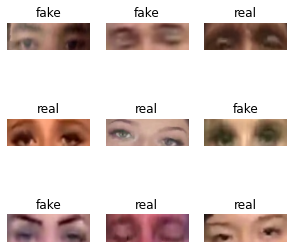

In [6]:
plt.figure(figsize=(5,5))
for images, labels in datasets[0][0].take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

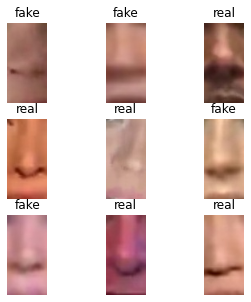

In [7]:
plt.figure(figsize=(5,5))
for images, labels in datasets[1][0].take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

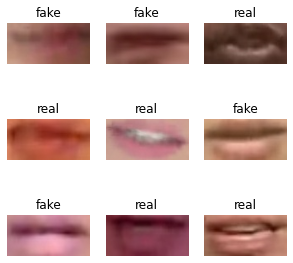

In [8]:
plt.figure(figsize=(5,5))
for images, labels in datasets[2][0].take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.005),
])

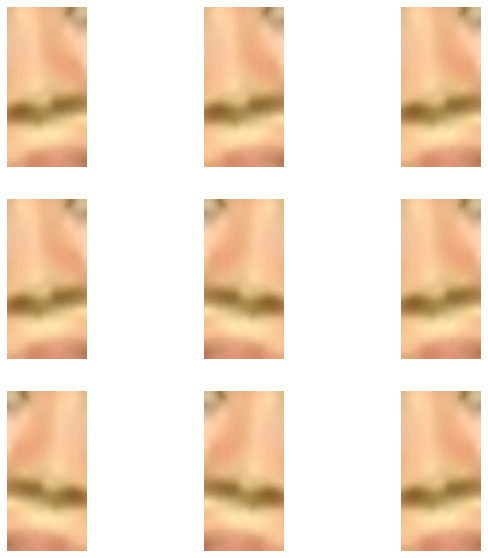

In [10]:
for image, _ in datasets[1][0].take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Model

In [11]:
'''
def Meso4VGG16(input_shape):
    input = Input(shape = input_shape) 
    x = data_augmentation(input)
    x = tf.keras.applications.xception.preprocess_input(x)

    x1 = Conv2D(8, (3, 3), input_shape=input_shape, padding='same', activation = 'relu')(x)
    x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    x2 = Conv2D(16, (3, 3), padding='same', activation = 'relu')(x1)
    x2 = Conv2D(16, (3, 3), padding='same', activation = 'relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
    x3 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(x2)
    x3 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(x3)
    x3 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    x4 = Conv2D(64, (3, 3), padding='same', activation = 'relu')(x3)
    x4 = Conv2D(64, (3, 3), padding='same', activation = 'relu')(x4)
    x4 = Conv2D(64, (3, 3), padding='same', activation = 'relu')(x4)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    x5 = Conv2D(128, (5, 5), padding='same', activation = 'relu')(x4)
    x5 = Conv2D(128, (5, 5), padding='same', activation = 'relu')(x5)
    x5 = Conv2D(128, (5, 5), padding='same', activation = 'relu')(x5)
    x5 = BatchNormalization()(x5)
    x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)

    y = Flatten()(x5)
    y = Dropout(0.5)(y)
    y = Dense(32)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(16)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(1, activation = 'sigmoid')(y)

    model = Model(inputs=input, outputs=y)
    return model

models = []

eyes_model = Meso4VGG16(input_shape=EYES_SHAPE)
optimizer = tf.keras.optimizers.Adam(lr = 0.00001)
eyes_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['accuracy'])

nose_model = Meso4VGG16(input_shape=NOSE_SHAPE)
optimizer = tf.keras.optimizers.Adam(lr = 0.00001)
nose_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['accuracy'])

lips_model = Meso4VGG16(input_shape=LIPS_SHAPE)
optimizer = tf.keras.optimizers.Adam(lr = 0.00001)
lips_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['accuracy'])

models.append(eyes_model)
models.append(nose_model)
models.append(lips_model)
models[0].summary()
'''

"\ndef Meso4VGG16(input_shape):\n    input = Input(shape = input_shape) \n    x = data_augmentation(input)\n    x = tf.keras.applications.xception.preprocess_input(x)\n\n    x1 = Conv2D(8, (3, 3), input_shape=input_shape, padding='same', activation = 'relu')(x)\n    x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x1)\n    x1 = BatchNormalization()(x1)\n    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)\n    x2 = Conv2D(16, (3, 3), padding='same', activation = 'relu')(x1)\n    x2 = Conv2D(16, (3, 3), padding='same', activation = 'relu')(x2)\n    x2 = BatchNormalization()(x2)\n    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)\n    x3 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(x2)\n    x3 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(x3)\n    x3 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(x3)\n    x3 = BatchNormalization()(x3)\n    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)\n    x4 = Conv2D(64, (3, 3), pa

In [12]:
def Meso4(input_shape): 
    input = Input(shape = input_shape) 
    x = data_augmentation(input)
    x = tf.keras.applications.xception.preprocess_input(x)
    
    x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
    
    x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    
    x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
    
    y = Flatten()(x4)
    y = Dropout(0.5)(y)
    y = Dense(16)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(1, activation = 'sigmoid')(y)

    return Model(inputs = input, outputs = y)

models = []

eyes_model = Meso4(input_shape=EYES_SHAPE)
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
eyes_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['accuracy'])

nose_model = Meso4(input_shape=NOSE_SHAPE)
optimizer = tf.keras.optimizers.Adam(lr = 0.001)
nose_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['accuracy'])

lips_model = Meso4(input_shape=LIPS_SHAPE)
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
lips_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['accuracy'])

models.append(eyes_model)
models.append(nose_model)
models.append(lips_model)
models[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 150, 3)]      0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 50, 150, 3)        0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 50, 150, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 150, 8)        224       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 150, 8)        32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 75, 8)         0     

## Callbacks

In [13]:
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    print("{0:.8f}".format(lr))
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1,
    mode='auto', min_lr=0
    )

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True
    )

checkpoint_eyes = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Eyes-{epoch:02d}-{val_accuracy:.4f}.h5", #File name includes epoch and validation accuracy.,
    save_weights_only=False,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )

checkpoint_nose = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Nose-{epoch:02d}-{val_accuracy:.4f}.h5", #File name includes epoch and validation accuracy.,
    save_weights_only=False,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )

checkpoint_lips = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Lips-{epoch:02d}-{val_accuracy:.4f}.h5", #File name includes epoch and validation accuracy.,
    save_weights_only=False,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )

## Eyes Model Training

In [14]:
history0 = models[0].fit(datasets[0][0], 
                epochs=TRAINING_EPOCHS, 
                validation_data=datasets[0][1], 
                callbacks=[reduce_lr, early_stopping, checkpoint_eyes],
                verbose=1)
models[0].save("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/model0.h5")

Epoch 1/50
6019/6019 [==============================] - 498s 80ms/step - loss: 0.7429 - accuracy: 0.6018 - val_loss: 0.4743 - val_accuracy: 0.7787

Epoch 00001: val_accuracy improved from -inf to 0.77867, saving model to /content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Eyes-01-0.7787.h5
Epoch 2/50
6019/6019 [==============================] - 243s 40ms/step - loss: 0.4931 - accuracy: 0.7591 - val_loss: 0.4396 - val_accuracy: 0.7771

Epoch 00002: val_accuracy did not improve from 0.77867
Epoch 3/50
6019/6019 [==============================] - 257s 43ms/step - loss: 0.4163 - accuracy: 0.8057 - val_loss: 0.4145 - val_accuracy: 0.7815

Epoch 00003: val_accuracy improved from 0.77867 to 0.78154, saving model to /content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Eyes-03-0.7815.h5
Epoch 4/50
6019/6019 [==============================] - 257s 43ms/step - loss: 0.3659 - accuracy: 0.8350 - val_loss: 0.3857 - val_accuracy: 0.8077

Ep

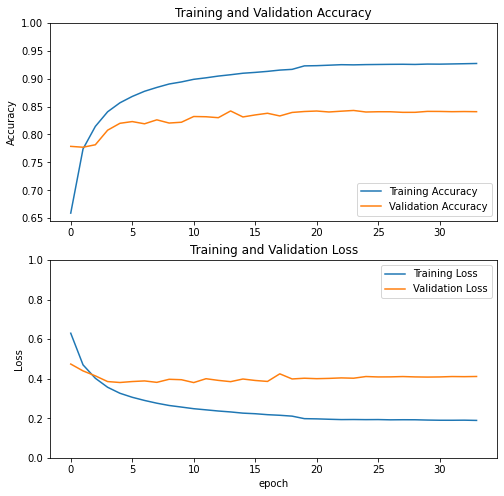

In [15]:
acc = history0.history['accuracy']
val_acc = history0.history['val_accuracy']

loss = history0.history['loss']
val_loss = history0.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# plt.savefig('/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble/training graph.png')

## Nose Model Training

In [16]:
history1 = models[1].fit(datasets[1][0], 
                epochs=TRAINING_EPOCHS, 
                validation_data=datasets[1][1], 
                callbacks=[reduce_lr, early_stopping, checkpoint_nose],
                verbose=1)
models[1].save("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/model1.h5")

Epoch 1/50
6019/6019 [==============================] - 498s 83ms/step - loss: 0.6109 - accuracy: 0.6780 - val_loss: 0.5611 - val_accuracy: 0.7135

Epoch 00001: val_accuracy improved from -inf to 0.71346, saving model to /content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Nose-01-0.7135.h5
Epoch 2/50
6019/6019 [==============================] - 227s 38ms/step - loss: 0.4326 - accuracy: 0.7997 - val_loss: 0.5714 - val_accuracy: 0.7314

Epoch 00002: val_accuracy improved from 0.71346 to 0.73138, saving model to /content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Nose-02-0.7314.h5
Epoch 3/50
6019/6019 [==============================] - 224s 37ms/step - loss: 0.3872 - accuracy: 0.8260 - val_loss: 0.6112 - val_accuracy: 0.7321

Epoch 00003: val_accuracy improved from 0.73138 to 0.73206, saving model to /content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Nose-03-0.7321.h5
Epoch 4/50
6019/6019 [======

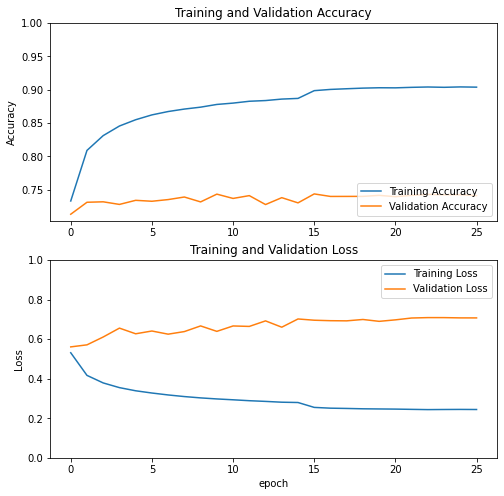

In [17]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Lips Model Training

In [18]:
history2 = models[2].fit(datasets[2][0], 
                epochs=TRAINING_EPOCHS, 
                validation_data=datasets[2][1], 
                callbacks=[reduce_lr, early_stopping, checkpoint_lips],
                verbose=1)
models[2].save("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/model2.h5")

Epoch 1/50
6019/6019 [==============================] - 482s 80ms/step - loss: 0.7903 - accuracy: 0.6085 - val_loss: 0.5076 - val_accuracy: 0.7700

Epoch 00001: val_accuracy improved from -inf to 0.77002, saving model to /content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Lips-01-0.7700.h5
Epoch 2/50
6019/6019 [==============================] - 238s 39ms/step - loss: 0.5295 - accuracy: 0.7400 - val_loss: 0.4461 - val_accuracy: 0.7991

Epoch 00002: val_accuracy improved from 0.77002 to 0.79910, saving model to /content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/training data/Lips-02-0.7991.h5
Epoch 3/50
6019/6019 [==============================] - 238s 39ms/step - loss: 0.4775 - accuracy: 0.7726 - val_loss: 0.4397 - val_accuracy: 0.7986

Epoch 00003: val_accuracy did not improve from 0.79910
Epoch 4/50
6019/6019 [==============================] - 237s 39ms/step - loss: 0.4520 - accuracy: 0.7892 - val_loss: 0.4170 - val_accuracy: 0.8125

Ep

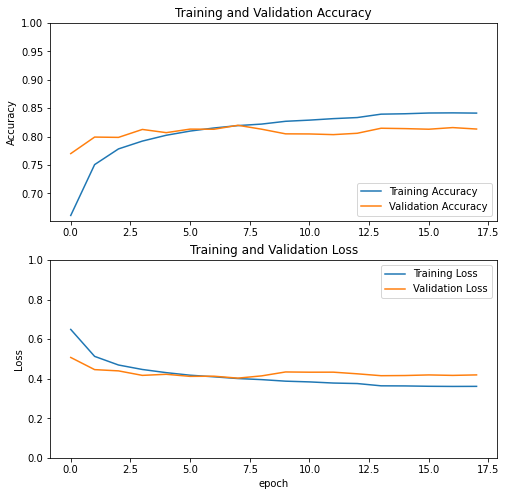

In [19]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Prediction

##Load Model

In [20]:
eyes_model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/model0.h5")
nose_model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/model1.h5")
lips_model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/model2.h5")

## Store into tf.data.Dataset

In [21]:
eyes_test = os.path.join('FaceForensics Extracted Landmarks', 'Eyes', 'non_aligned', 'testing')
nose_test = os.path.join('FaceForensics Extracted Landmarks', 'Nose', 'non_aligned', 'testing')
lips_test = os.path.join('FaceForensics Extracted Landmarks', 'Lips', 'non_aligned', 'testing')

# When shuffle = False, set seed = None (default value)
# When shuffle = false and seed = random int value, 
# then a single image is extracted multiple times

class_names = None
def get_datasets(testing_directory, image_size):
    ds_test = tf.keras.preprocessing.image_dataset_from_directory(
        testing_directory,
        color_mode="rgb",
        batch_size=1000,
        image_size=image_size,
        shuffle=True,
        seed=9,
    )
    global class_names
    class_names = ds_test.class_names
    print(ds_test.class_names)
    
    AUTOTUNE = tf.data.AUTOTUNE
    ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

    return ds_test

datasets = []
eyes_ds = get_datasets(eyes_test, EYES_SIZE)
datasets.append(eyes_ds)
nose_ds = get_datasets(nose_test, NOSE_SIZE)
datasets.append(nose_ds)
lips_ds = get_datasets(lips_test, LIPS_SIZE)
datasets.append(lips_ds)

Found 27962 files belonging to 2 classes.
['fake', 'real']
Found 27962 files belonging to 2 classes.
['fake', 'real']
Found 27962 files belonging to 2 classes.
['fake', 'real']


##Make Prediction

###Eyes Prediction

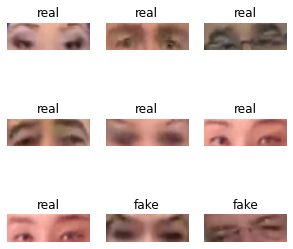

In [22]:
eyes_image_batch, eyes_label_batch = datasets[0].as_numpy_iterator().next()
eyes_predictions_batch = eyes_model.predict_on_batch(eyes_image_batch).flatten()
eyes_predictions_batch = tf.where(eyes_predictions_batch < 0.5, 0, 1)
eyes_predictions_batch

plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(eyes_image_batch[i].astype("uint8"))
    plt.title(class_names[eyes_predictions_batch[i]])
    plt.axis("off")

## Classification Report

In [23]:
from sklearn.metrics import classification_report
classificationReport = classification_report(eyes_label_batch, eyes_predictions_batch, target_names=class_names, digits=5)
print(classificationReport)

              precision    recall  f1-score   support

        fake    0.84074   0.87140   0.85580       521
        real    0.85435   0.82046   0.83706       479

    accuracy                        0.84700      1000
   macro avg    0.84754   0.84593   0.84643      1000
weighted avg    0.84726   0.84700   0.84682      1000



## Confusion Matrix

In [24]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    return cm
    
confusionMatrix = print_confusion_matrix(eyes_label_batch, eyes_predictions_batch)

True positive =  454
False positive =  67
False negative =  86
True negative =  393


# Write to File

In [25]:
tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + 'LandmarksTraining' + '\n' +
    'Batch Size: ' + str(BATCH_SIZE) + '\n' +
    'Training Epochs: ' + str(TRAINING_EPOCHS) + '\n' +
    'All data below are from EYES prediction only' + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' LandmarksTraining' + '.txt')

myFile = open('/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/' + filename, 'w')
myFile.write(data)
myFile.close()
